In [1]:
import os
import math
import pandas as pd
import numpy as np
import umap
from functools import reduce
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

# Configuration settings
from chasm.config import CONFIG

# PLINK preprocessing utilities
from chasm.plink_preprocessing import (
    concat_AFs, 
    divide_into_chunks, 
    make_ids,
    make_AFs
)

from chasm.data_preprocessing import (
    is_snp,
    make_df,
    calculate_AFs,
    merge_AFs_ensembl_build,
    divide_into_chunks,
    divide_into_lds,
    align_dataframes,
)
from chasm.gwas import ols_regression, pca_of_n_snps, project_on_dimensions

from chasm.visualization import make_population_plot, plot_training_history
from chasm.ld_blocks import segmenter
from chasm.abyss import linear_abyss, AE, decoder, create_meta_decoder_n

from chasm.fst import make_fst, make_global_fst
from chasm.cluster import silhouette_score_clusters, concat_dims_one_hot, concat_dims

2025-03-06 12:24:17.584357: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 12:24:17.639018: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 12:24:18.056374: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 12:24:18.058445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-06 12:24:19.020907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [3]:
# Changing the GTM data into a pickle file having an id file and calculating the AFs for each SNP 
# with the CHROM:POS for every corresponding RSID

# GTM data
"""
path_data_raw = f"{CONFIG['PATH_data']}/00_raw/recoded_1000G.raw"
path_raw = f"{CONFIG['PATH_data']}/01_raw/"
path_usefull = f"{CONFIG['PATH_data']}/02_usefull/"

geno = make_df(path_data_raw, path_usefull, path_raw)

afs = calculate_AFs(geno)

path_ensembl = f"/mnt/e/1000G_data/usefull/ensembl_build"
merge_AFs_ensembl_build(path_ensembl, path_usefull, afs)
"""
# Divide the AFs into chunks
"""
size_chunck = 20_000
min_maf = 0.01

path_raw = f"{CONFIG['PATH_data']}/01_raw/geno.pkl"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_output = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"

divide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)
"""

'\nsize_chunck = 20_000\nmin_maf = 0.01\n\npath_raw = f"{CONFIG[\'PATH_data\']}/01_raw/geno.pkl"\npath_afs = f"{CONFIG[\'PATH_data\']}/02_usefull/allele_frequencies.pkl"\npath_output = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF/"\n\ndivide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)\n'

In [5]:
"""
path_chunks = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"
path_output = f"{CONFIG['PATH_data']}/04_ld_blocks/"
n_components = 10
size_block = 1000
os.listdir(path_chunks)
chroms = [f for f in os.listdir(path_chunks) if f.startswith("chrom")]
for chrom in chroms:
    path_chrom = f"{path_chunks}{chrom}/"
    path_output_chrom = f"{path_output}{chrom}/"
    os.makedirs(path_output_chrom, exist_ok=True)
    chunks = [f for f in os.listdir(path_chrom) if f.startswith("chunk")]
    for chunk in chunks:
        name_chunk = chunk.split(".pkl")[0]
        divide_into_lds(path_chrom, path_output_chrom, name_chunk, n_components, size_block)
"""


'\npath_chunks = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF/"\npath_output = f"{CONFIG[\'PATH_data\']}/04_ld_blocks/"\nn_components = 10\nsize_block = 1000\nos.listdir(path_chunks)\nchroms = [f for f in os.listdir(path_chunks) if f.startswith("chrom")]\nfor chrom in chroms:\n    path_chrom = f"{path_chunks}{chrom}/"\n    path_output_chrom = f"{path_output}{chrom}/"\n    os.makedirs(path_output_chrom, exist_ok=True)\n    chunks = [f for f in os.listdir(path_chrom) if f.startswith("chunk")]\n    for chunk in chunks:\n        name_chunk = chunk.split(".pkl")[0]\n        divide_into_lds(path_chrom, path_output_chrom, name_chunk, n_components, size_block)\n'

# Choose SNPs to project on n dimensions

# Observe raw dimensions

In [6]:
path_ids = f"{CONFIG['PATH_data']}/02_usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/00_raw/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
ids = ids.merge(labels, left_on="IID", right_on="Sample name")

Running iteration 2
The optimal number of clusters is: 5


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


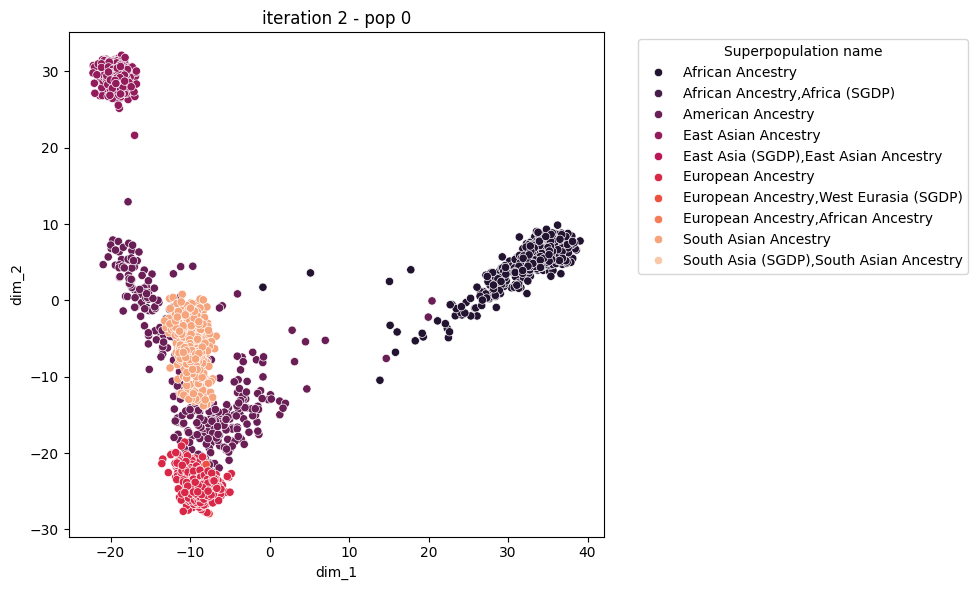

Running iteration 3
The optimal number of clusters is: 4


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 2


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 3


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 3


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 5


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


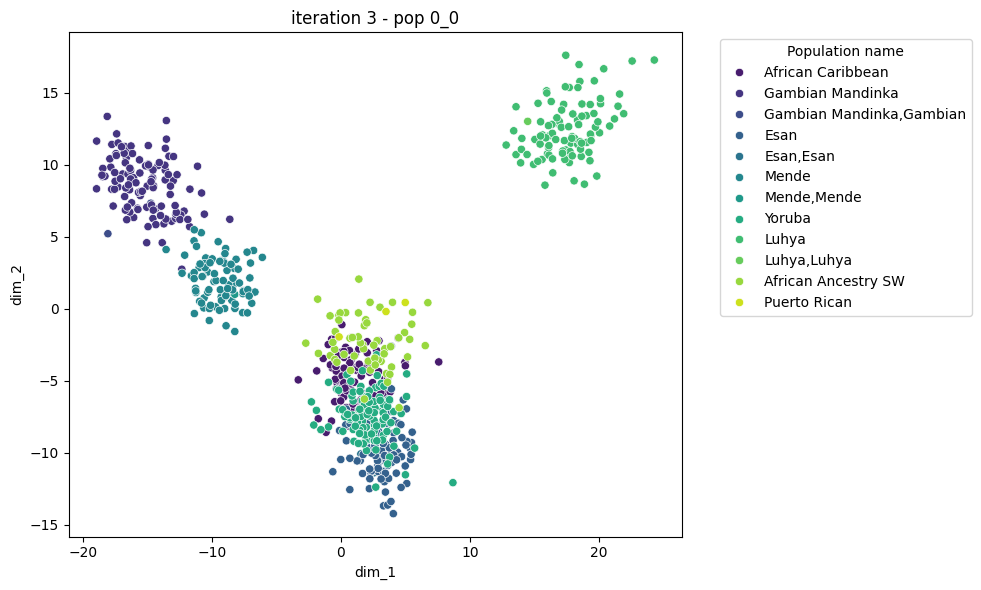

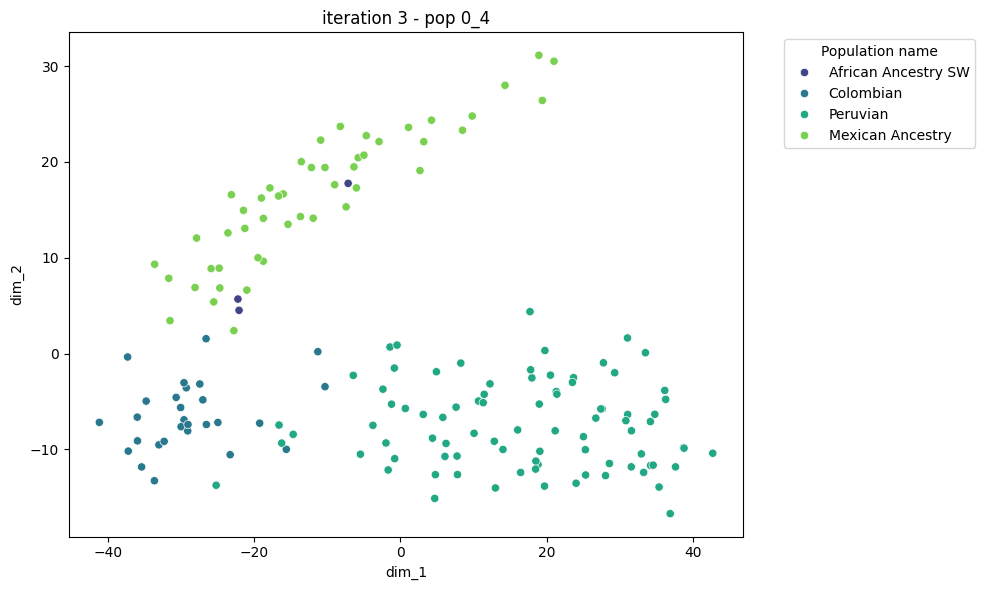

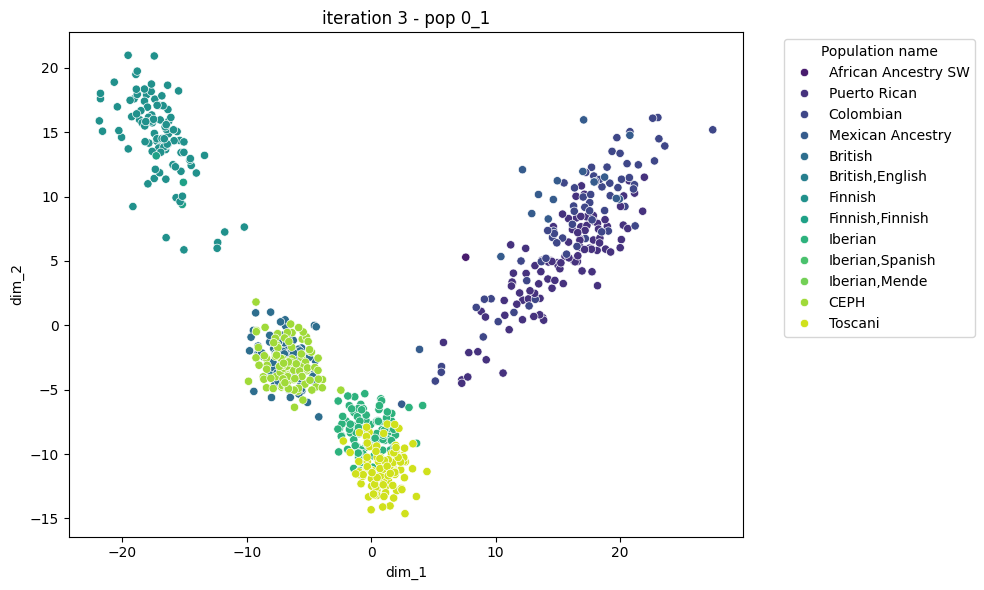

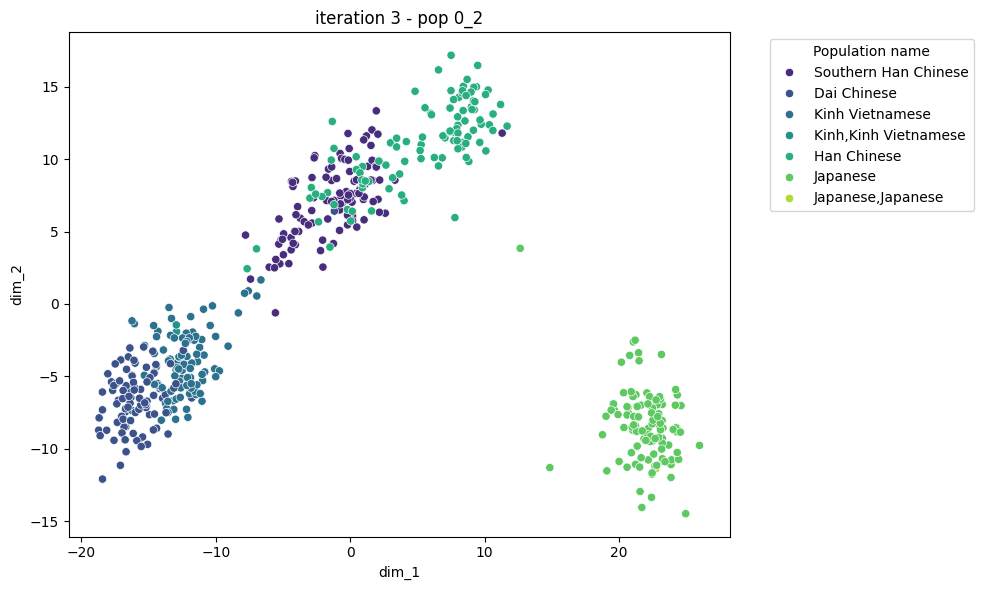

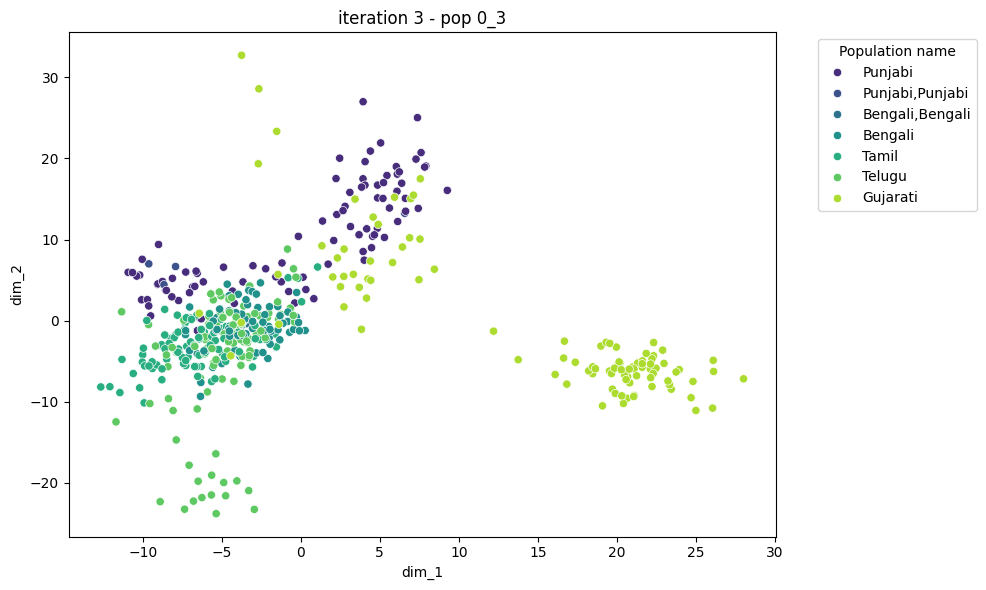

Running iteration 4
The optimal number of clusters is: 4


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 2


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 3


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 2


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 3


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 3


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 2


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 4


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 2


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 2


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 2


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 8


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 2


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 3


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 2


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 2


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The optimal number of clusters is: 2


/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


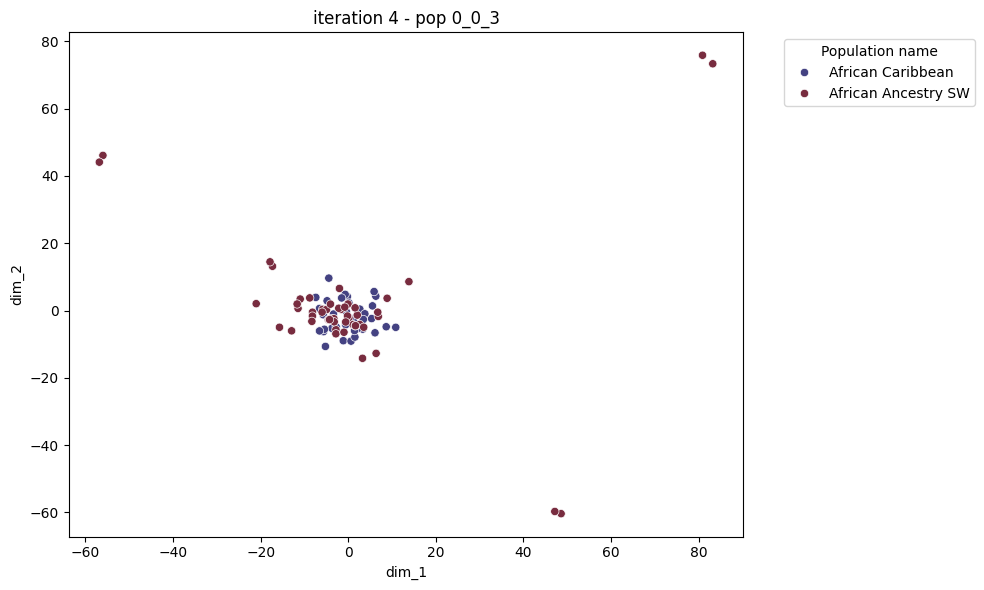

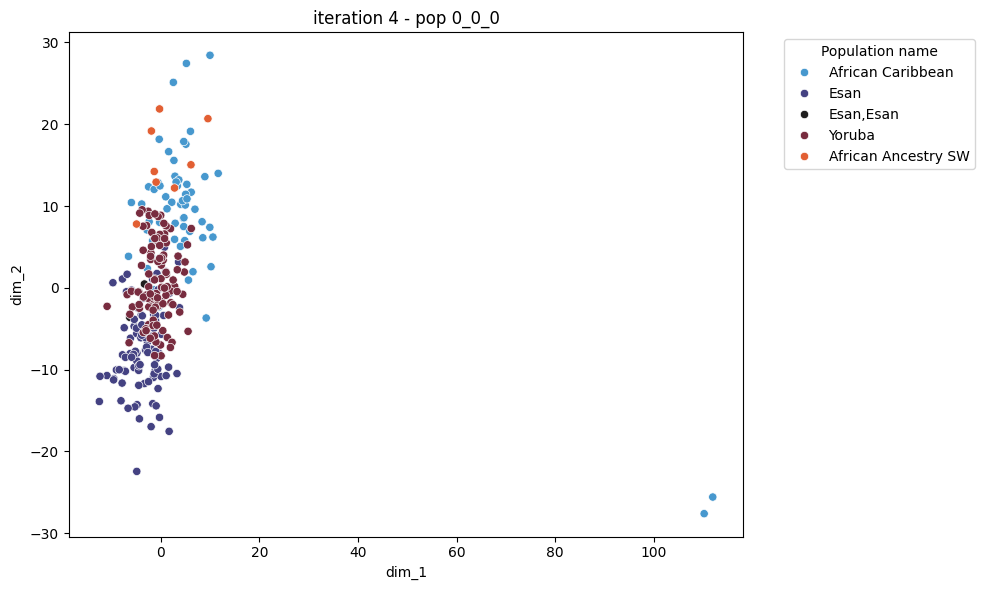

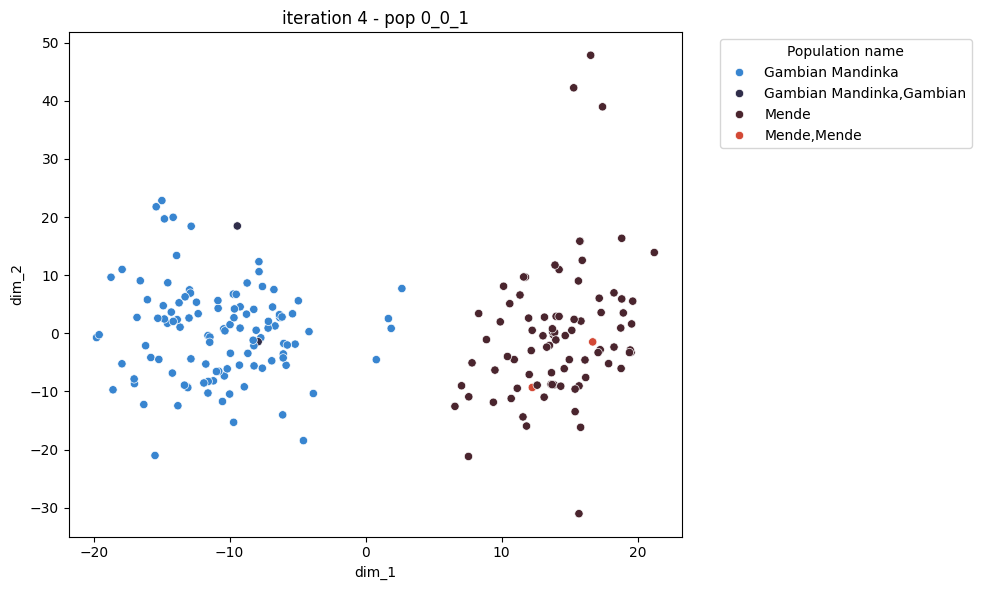

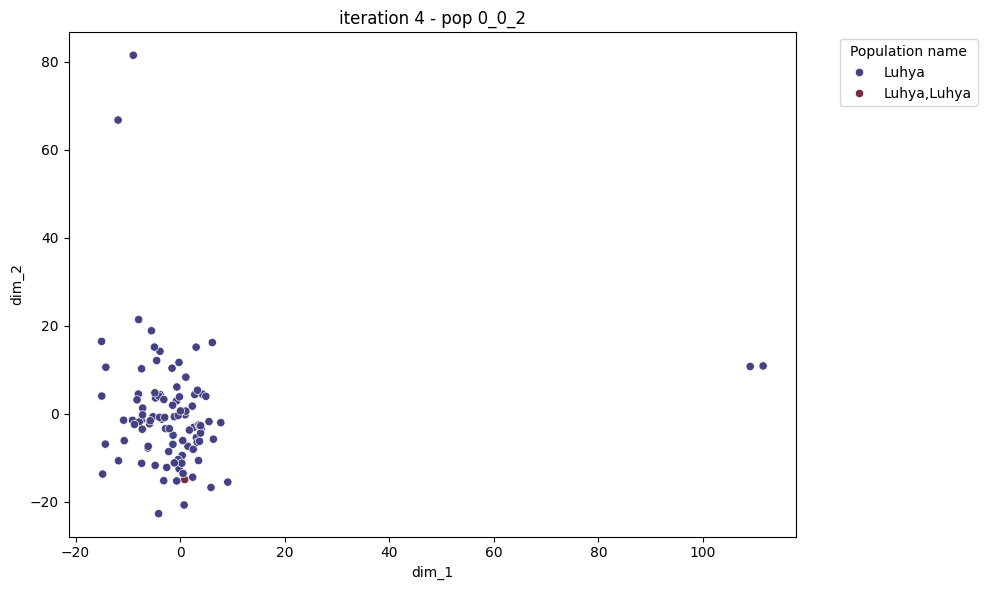

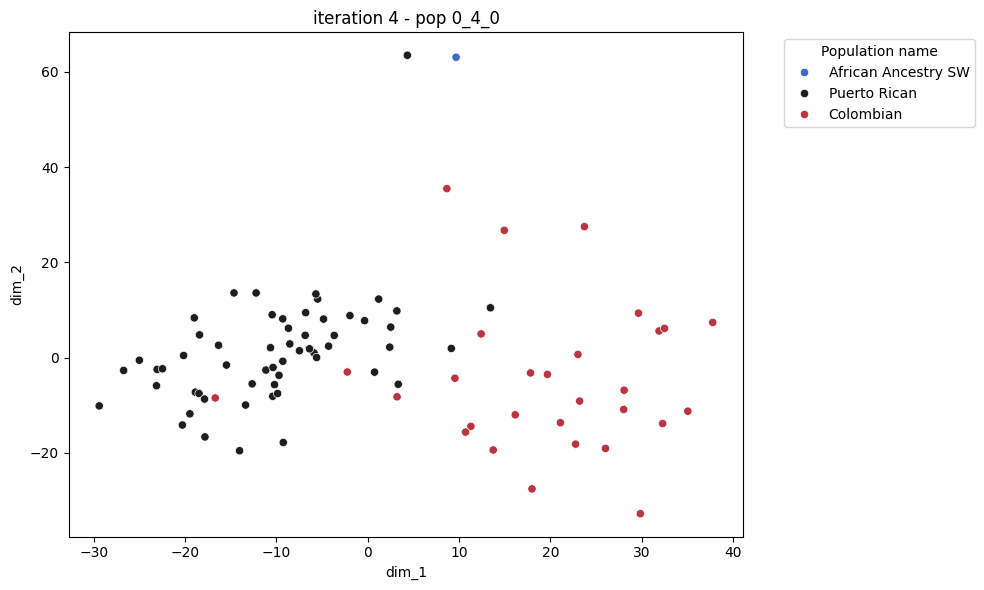

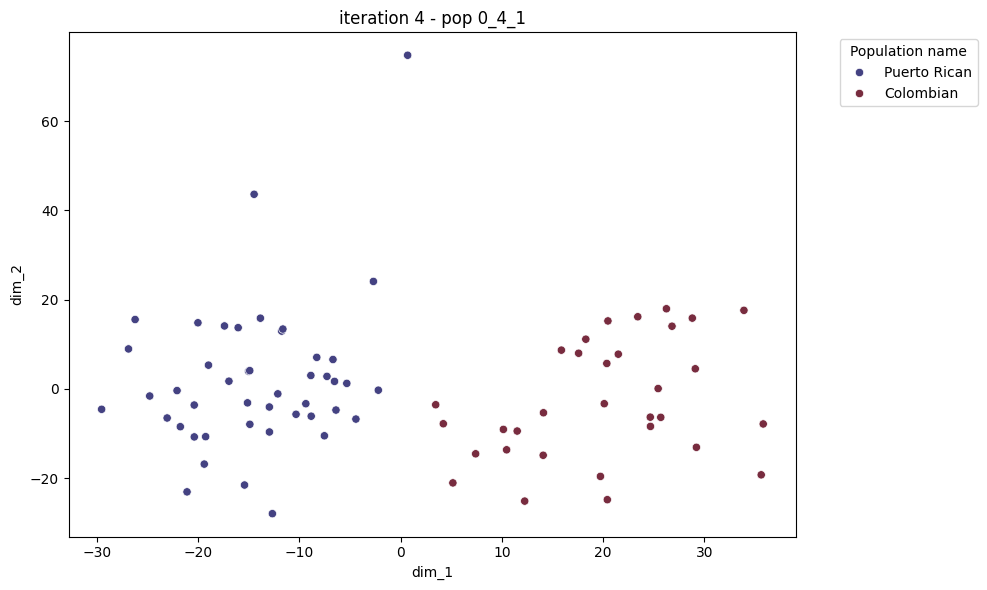

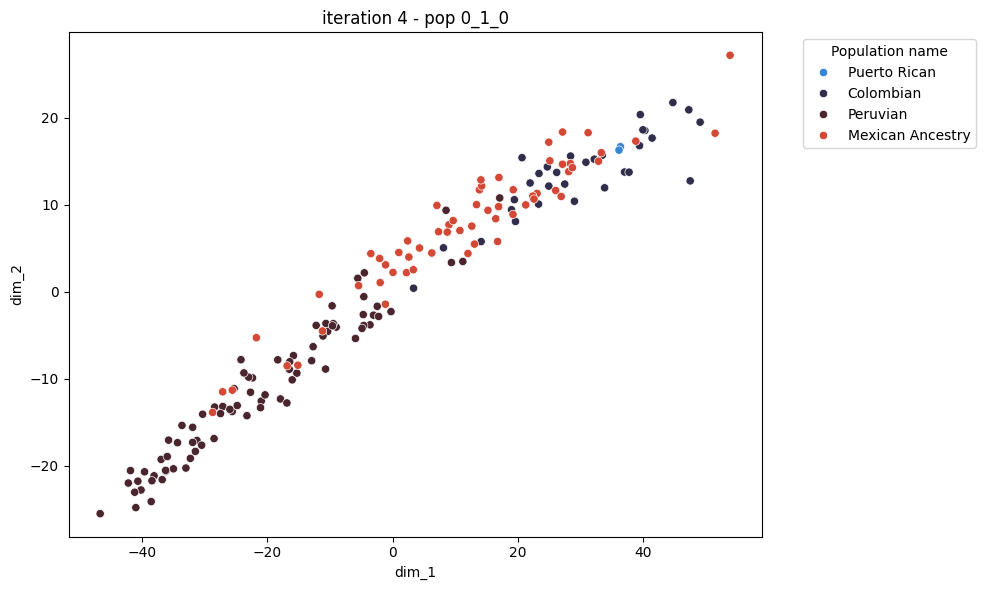

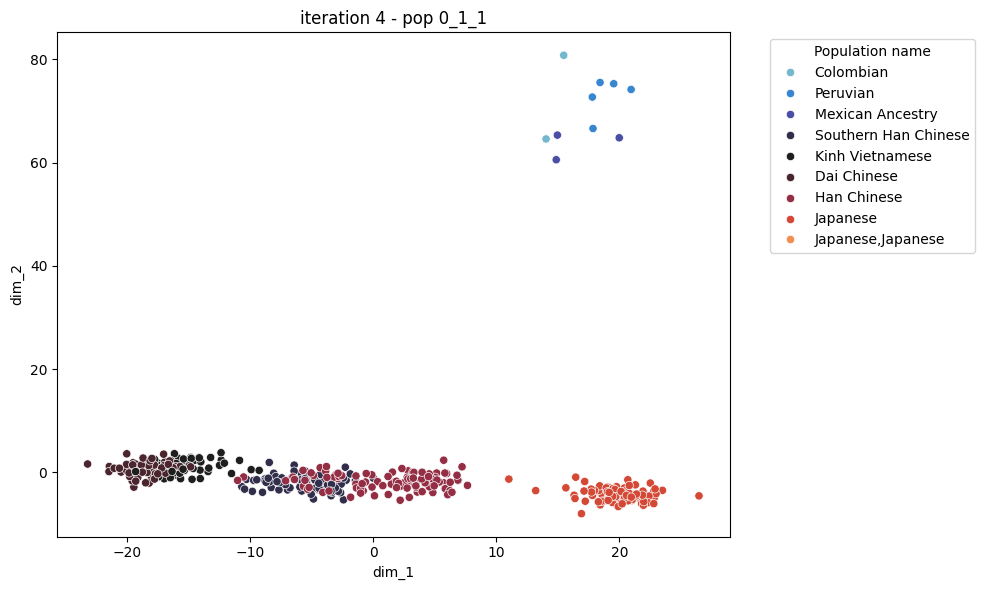

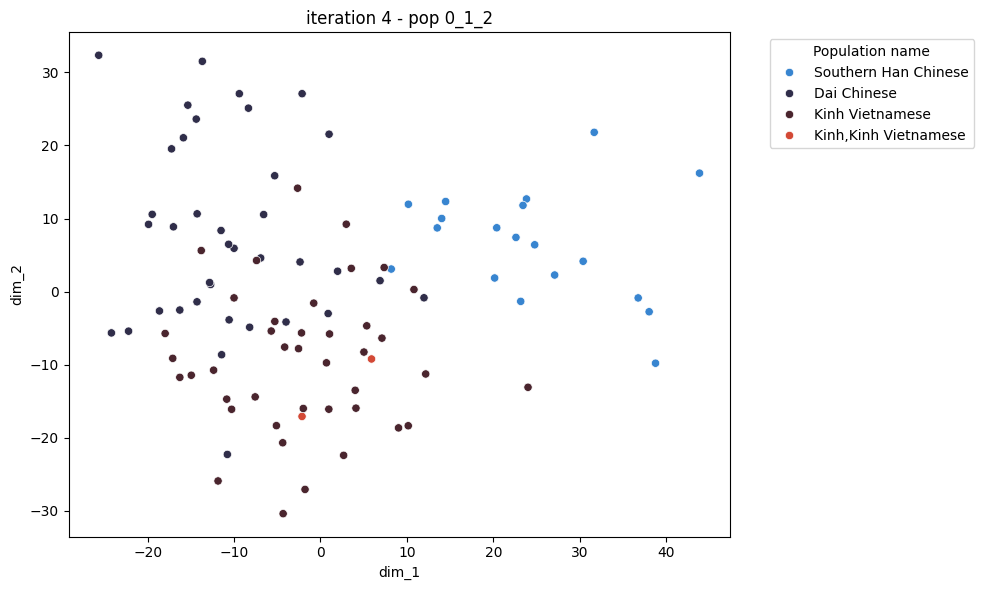

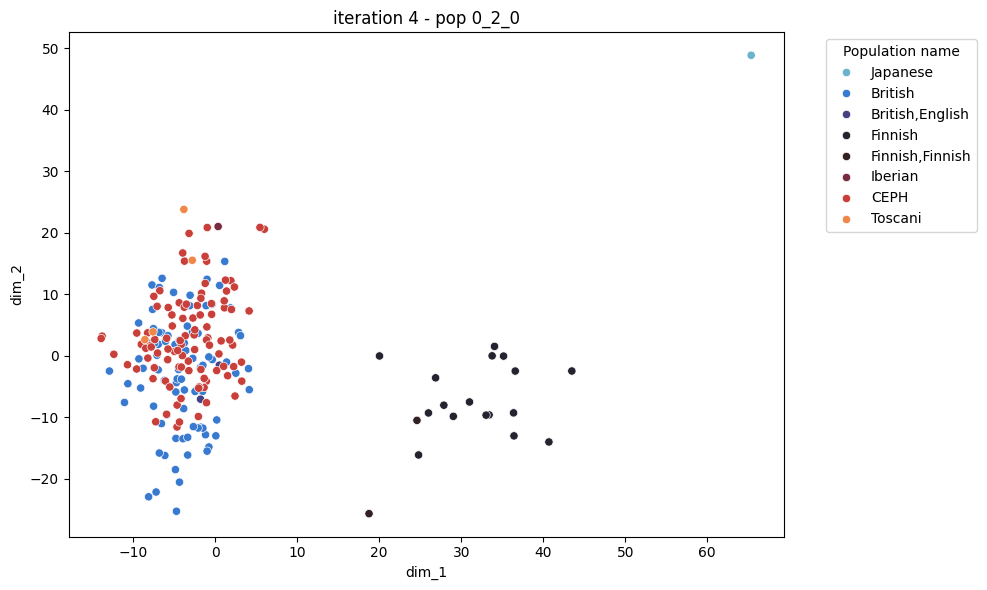

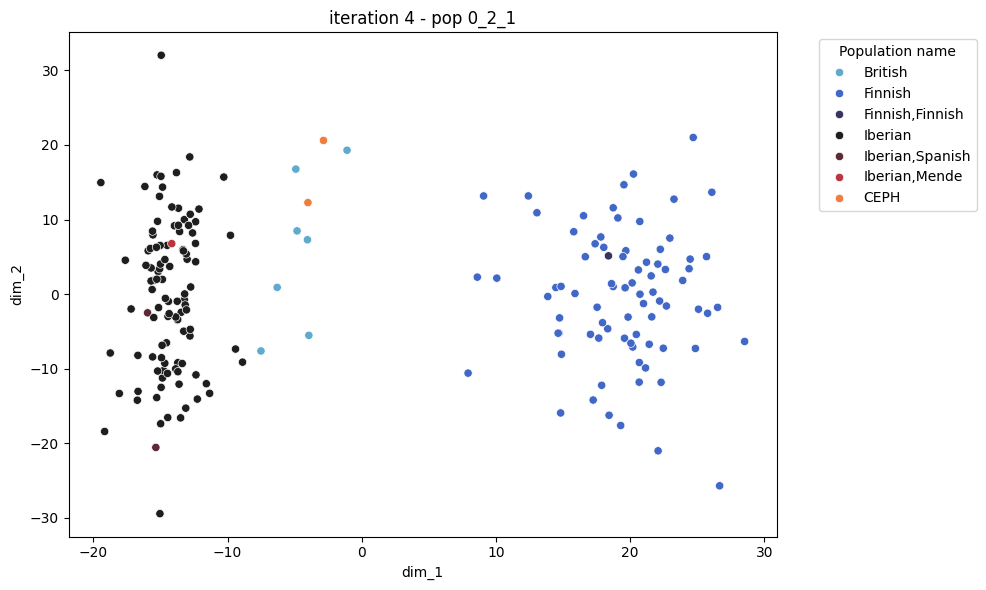

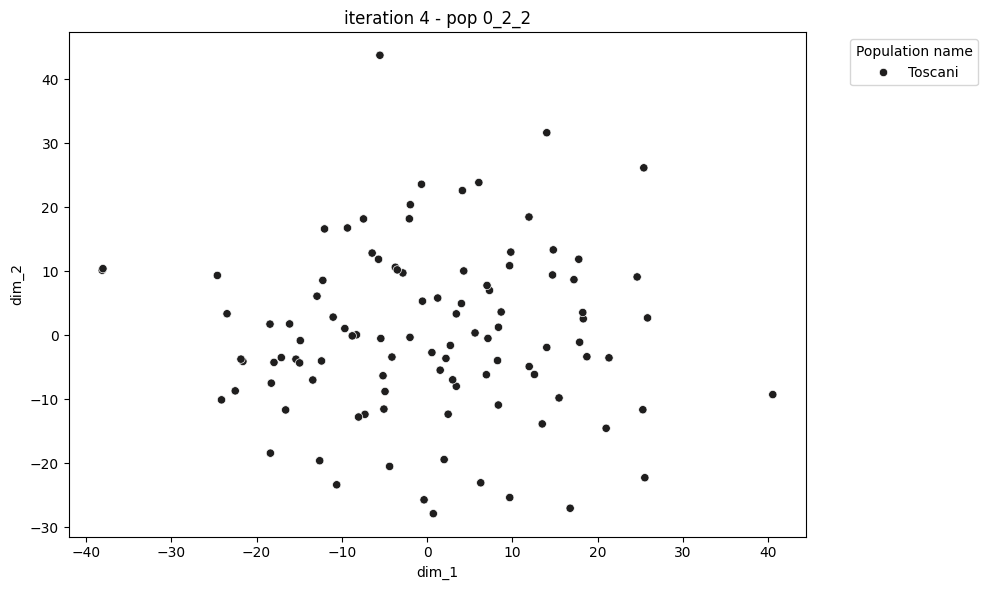

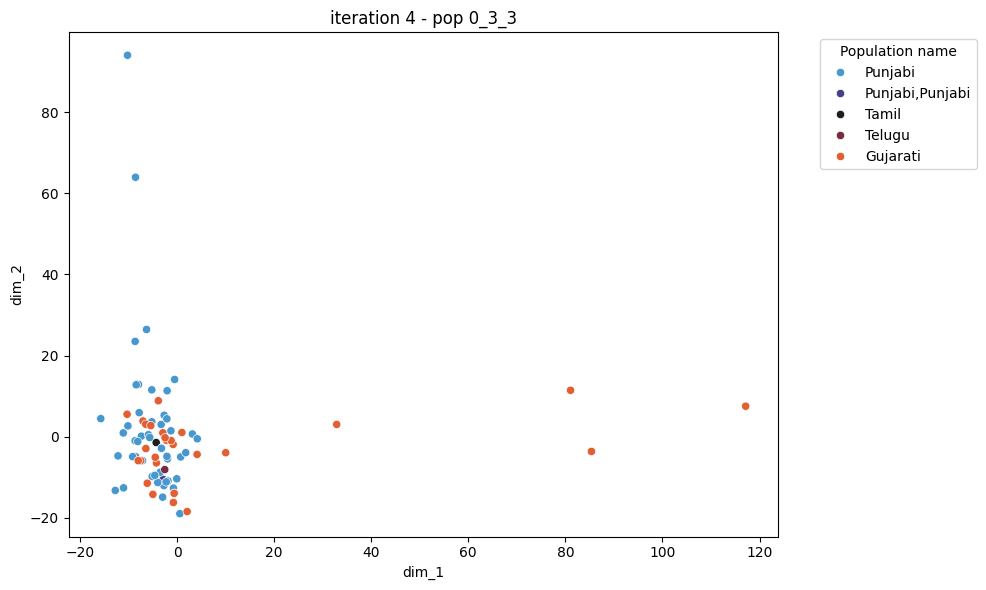

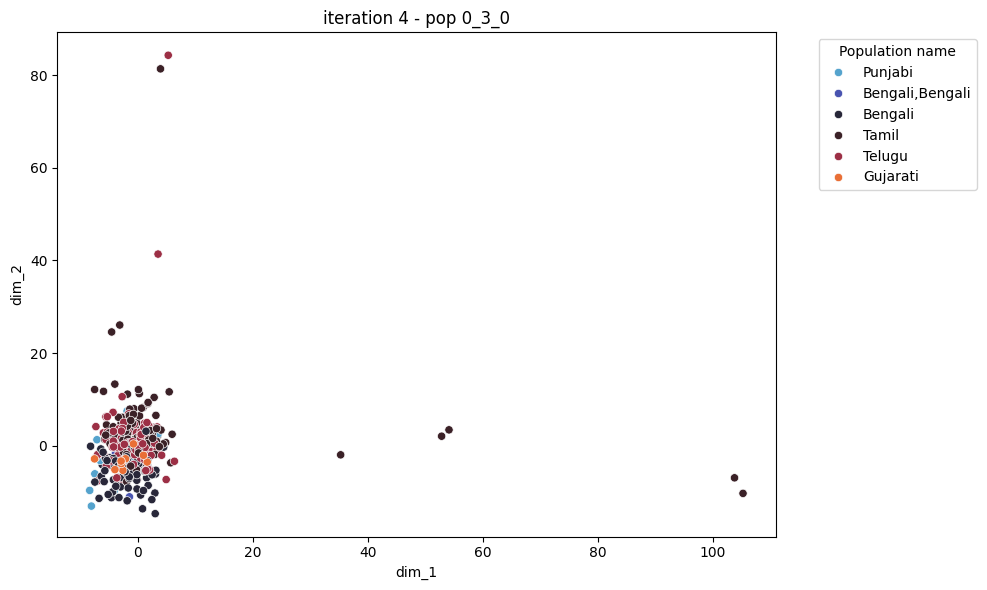

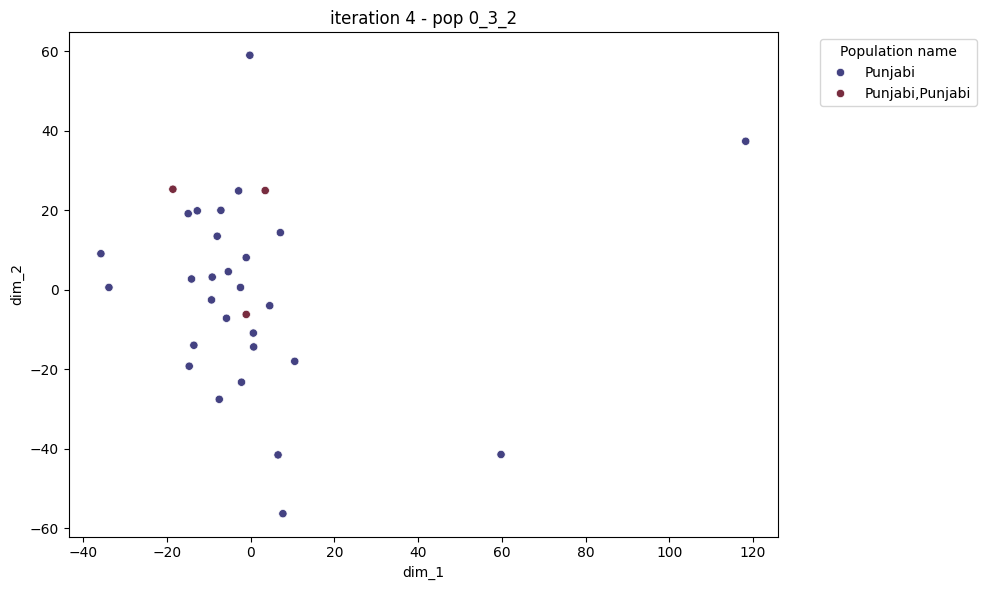

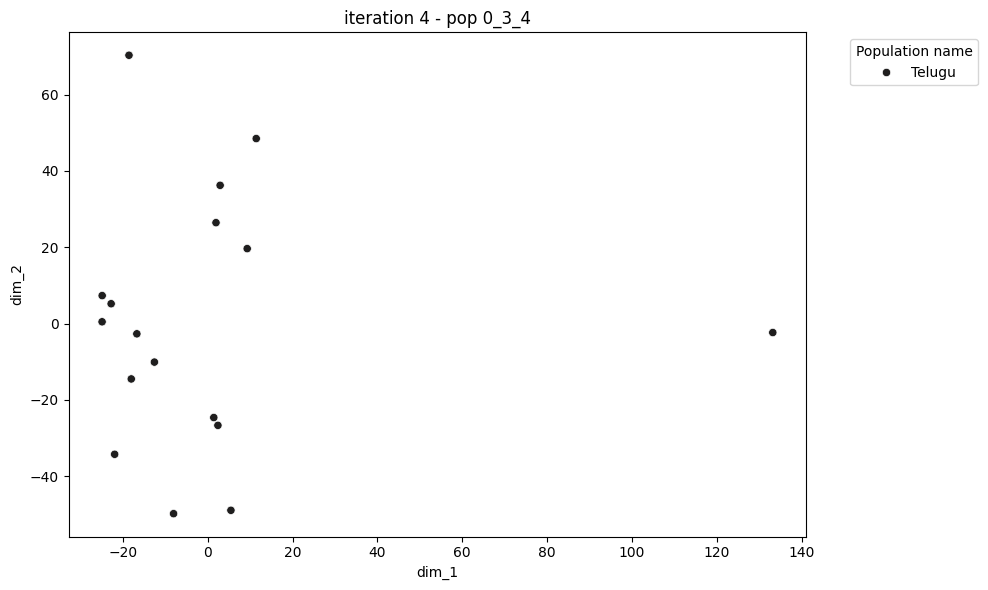

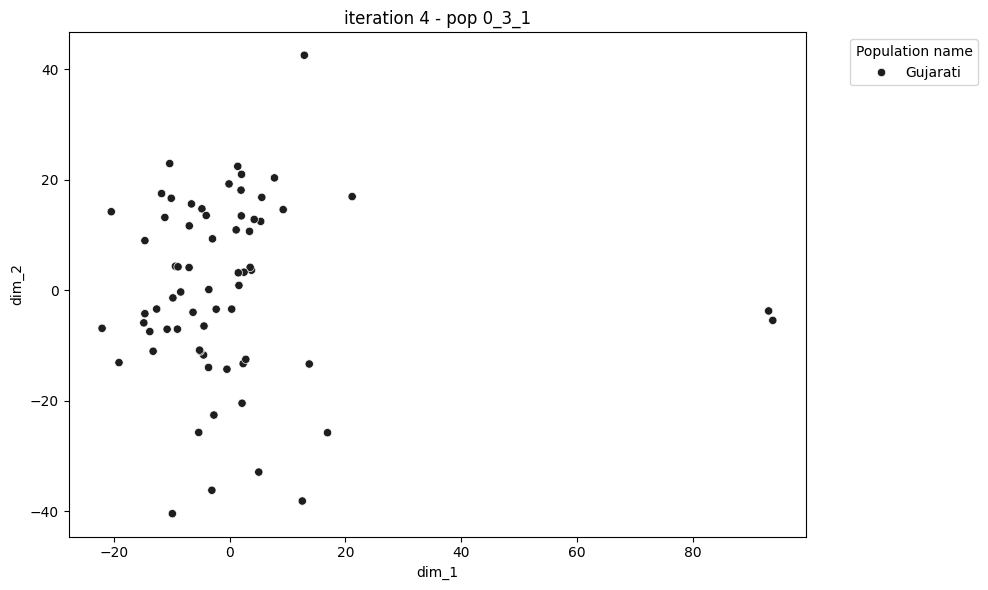

In [ ]:
# taking the first PC of the SNP data then finding the snps which describe the most variance
# doing PCA of the residual snps and reiterating the process nr_of_projected_dimensions times
# when having our projected dims explained by groups of snps, we can cluster the individuals based on silhouette scores
# and then we can assign the individuals to the clusters and repeat the process iterations times
"""

path_macro_similar = f"{CONFIG['PATH_data']}/04_ld_blocks/"
iterations = 3
palette_nr = 0
palettes = ['rocket', 'viridis', 'icefire', 'magma', 'plasma', 'inferno', 'cividis', 'twilight', 'twilight_shifted', 'hsv', 'crest', 'brylant', 'vlag', 'deep', 'dense', 'turbo', 'crest', 'delta', 'curl', 'cubehelix', 'phase', 'twilight', 'twilight_shifted', 'hsv', 'icefire', 'crest', 'brylant', 'vlag', 'deep', 'dense', 'turbo', 'crest', 'delta', 'curl', 'cubehelix', 'phase']
for iter in list(range(iterations)):
    iter += 2
    print(f"Running iteration {iter}")
    path_output = f"{CONFIG['PATH_data']}/iteration_{iter}/"
    
    if iter == 2:
        ids[f"cluster_{iter}"] = f"{0}"
        os.makedirs(f"{path_output}/pop_{0}", exist_ok=True)
        ids.to_pickle(f"{path_output}/pop_{0}/ids.pkl")
        
    else:
        pass
    
    cluster_to_add = []
    for sub_pop in ids[f"cluster_{iter}"].unique():
        path_output = f"{CONFIG['PATH_data']}/iteration_{iter}/pop_{sub_pop}/"
        os.makedirs(path_output, exist_ok=True)
        temp_ids = ids[ids[f"cluster_{iter}"] == sub_pop]
        nr_of_projected_dimensions = 4
        geno = project_on_dimensions(path_macro_similar, path_output, temp_ids, nr_of_projected_dimensions=3, nr_snps = 20_000, n_components = 10)
        
        existing_dims = []   
        for PCs in [f for f in os.listdir(path_output) if f.startswith('PCs')]:
            dim = PCs.split('PCs_')[1].split('.pkl')[0]
            path_PC = f"{path_output}/{PCs}"
            PCs = pd.read_pickle(f"{path_PC}")
            temp_ids = temp_ids.copy()
            temp_ids[dim] = list(PCs['PC1'])
            existing_dims.append(dim)
        labels = silhouette_score_clusters(temp_ids, existing_dims, plot=False)
        for element in labels:
            cluster_to_add.append(f"{sub_pop}_{element}")
            
    ids[f"cluster_{iter+1}"] = cluster_to_add
    ids.to_pickle(f"{CONFIG['PATH_data']}/iteration_{iter}/ids.pkl")
    
    # Vizualization
    path_input = f"{CONFIG['PATH_data']}/iteration_{iter}/"
    for pop in [f for f in os.listdir(path_input) if f.startswith('pop')]:
        pop = pop.split('pop_')[1]
        temp_ids = ids[ids[f"cluster_{iter}"] == pop]
        path_pop = f"{path_input}/pop_{pop}"
        for PCs in [f for f in os.listdir(path_pop) if f.startswith('PCs')]:
            dim = PCs.split('PCs_')[1].split('.pkl')[0]
            path_PC = f"{path_pop}/{PCs}"
            PCs = pd.read_pickle(f"{path_PC}")
            temp_ids = temp_ids.copy()
            temp_ids[dim] = list(PCs['PC1'])
        if len(list(temp_ids['Population name'].unique())) > 20:
            make_population_plot(temp_ids, 'dim_1', 'dim_2', 'Superpopulation name', f"iteration {iter} - pop {pop}", palette = f"{palettes[palette_nr]}")
        else:
            make_population_plot(temp_ids, 'dim_1', 'dim_2', 'Population name', f"iteration {iter} - pop {pop}", palette = f"{palettes[palette_nr]}")
    palette_nr += 1
"""


# Find the dims per snp

In [9]:

# Every dimensions is explained by certain snps, we want to know which snps are the most important for each dimension
"""
path_data = f"{CONFIG['PATH_data']}/"
iteration_files = [f for f in os.listdir(path_data) if f.startswith('iteration')]
snp_ids_dfs = []
for iteration in iteration_files:
    path_iteration = f"{path_data}/{iteration}/"
    for pop in [f for f in os.listdir(path_iteration) if f.startswith('pop')]:
        pop = pop.split('pop_')[1]
        path_snp_ids = f"{path_iteration}/pop_{pop}/snp_ids.pkl"
        snp_ids = pd.read_pickle(path_snp_ids)
        snp_ids = snp_ids.drop(columns=['pval', 'betas', '-logp'])
        snp_ids[f"{iteration}_pop_{pop}_dim"] = list(snp_ids['dim'])
        snp_ids = snp_ids.drop(columns=['dim'])
        snp_ids = snp_ids.sort_index()  # Now sort
        snp_ids_dfs.append(snp_ids)
        
snp_ids = reduce(lambda left, right: pd.merge(left, right, on='snp_rs'), snp_ids_dfs)
snp_ids.to_pickle(f"{CONFIG['PATH_data']}/02_usefull/post_iterations_snp_ids.pkl")
"""

'\npath_data = f"{CONFIG[\'PATH_data\']}/"\niteration_files = [f for f in os.listdir(path_data) if f.startswith(\'iteration\')]\nsnp_ids_dfs = []\nfor iteration in iteration_files:\n    path_iteration = f"{path_data}/{iteration}/"\n    for pop in [f for f in os.listdir(path_iteration) if f.startswith(\'pop\')]:\n        pop = pop.split(\'pop_\')[1]\n        path_snp_ids = f"{path_iteration}/pop_{pop}/snp_ids.pkl"\n        snp_ids = pd.read_pickle(path_snp_ids)\n        snp_ids = snp_ids.drop(columns=[\'pval\', \'betas\', \'-logp\'])\n        snp_ids[f"{iteration}_pop_{pop}_dim"] = list(snp_ids[\'dim\'])\n        snp_ids = snp_ids.drop(columns=[\'dim\'])\n        snp_ids = snp_ids.sort_index()  # Now sort\n        snp_ids_dfs.append(snp_ids)\n        \nsnp_ids = reduce(lambda left, right: pd.merge(left, right, on=\'snp_rs\'), snp_ids_dfs)\nsnp_ids.to_pickle(f"{CONFIG[\'PATH_data\']}/02_usefull/post_iterations_snp_ids.pkl")\n'

# Make autoencoder

In [16]:
# create one dimensional representation of the data

2025-03-06 15:10:31.058217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-06 15:10:31.058818: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


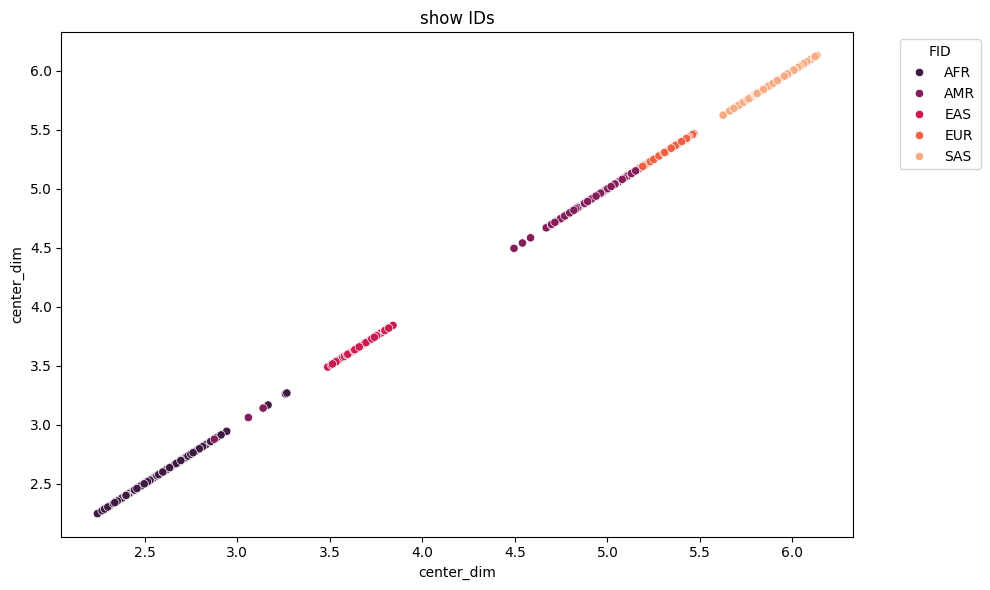

In [ ]:
"""
path_data = f"{CONFIG['PATH_data']}/iteration_2/pop_0/"
pop = '0'
dims_df = concat_dims(path_data, 3, pop)

hidden = 2
epoch = 500
patience = 10
[autoencoder, bottleneck_model, history] = AE(dims_df, 1, dims_df.shape[1]*2, epoch, patience)

bottle = bottleneck_model(dims_df.to_numpy())
bottleneck_df = pd.DataFrame(bottle, columns=['PC1'])
path_data = f"{CONFIG['PATH_data']}/iteration_1/pop_0/"
os.makedirs(path_data, exist_ok=True)
bottleneck_df.to_pickle(f"{path_data}/PCs_dim_1.pkl")

ids = pd.read_pickle(f"{CONFIG['PATH_data']}/02_usefull/ids.pkl")
ids['center_dim'] = list(bottleneck_df['PC1'])
ids.to_pickle(f"{CONFIG['PATH_data']}/02_usefull/ids_with_center_dim.pkl")
ids[f"cluster_1"] = pop
ids.to_pickle(f"{CONFIG['PATH_data']}/iteration_1/ids.pkl")

make_population_plot(ids, 'center_dim', 'center_dim', 'FID', f"show IDs", palette = 'rocket')
"""

# Use lower dimensional representation to create AF probabilities

In [12]:
# make for every dims a concatenated dataframe so we have a df with all the dims for every pop, sort of one hot encoded
"""
concat_dims_one_hot(CONFIG['PATH_data'], 3)
"""

"\nconcat_dims_one_hot(CONFIG['PATH_data'], 3)\n"

In [13]:
# create a meta decoder combining all the decoders

nr_hidden_layer = 2

iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]
iterations.sort()
for iteration in iterations:
    path_iteration = f"{CONFIG['PATH_data']}/{iteration}"
    iteration_nr = int(iteration.split('_')[1])
    print(f"Running iteration {iteration_nr}")
    path_iteration = f"{CONFIG['PATH_data']}/{iteration}/"
    decoders = []
    
    for i in range(iteration_nr):
        i += 1
        if i == iteration_nr:
            pass
        else:
            dim1 = pd.read_pickle(f"{CONFIG['PATH_data']}/{iterations[i-1]}/concated_one_hot_dims.pkl")
            dim2 = pd.read_pickle(f"{CONFIG['PATH_data']}/{iterations[i]}/concated_one_hot_dims.pkl")
            decoder_temp, decoder_history =  decoder(dim1, dim2, nr_hidden_layer, 100, 10)
            decoders.append(decoder_temp)
    if iteration_nr == 1:
        pass
    else:
        meta_iter = create_meta_decoder_n(decoders)
        
        
        # Ensure all layers are trainable (for fine-tuning)
        for layer in meta_iter.layers:
            layer.trainable = True
        # Compile the meta-decoder
        meta_iter.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
        meta_iter.save(f"{path_iteration}/meta_decoder.keras")


Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4


In [14]:
from keras.callbacks import EarlyStopping
from keras import backend as K
import gc

def create_one_hot_mafs(df, central, dim, to_keep, meta):
    # Create a minor allele frequency (MAF) mask
    db_minor = df.copy()
    db_minor = db_minor.applymap(lambda x: 1 if x == to_keep else 0)
    decoder_temp, decoder_history =  decoder(dim, db_minor, 2, 100, 10)
    chunk_decoder = create_meta_decoder_n([meta, decoder_temp])
    
    # Ensure all layers are trainable
    for layer in chunk_decoder.layers:
        layer.trainable = True

    # Compile the meta-decoder
    chunk_decoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    history = chunk_decoder.fit(
        central.to_numpy(), 
        db_minor.to_numpy(), 
        epochs=200, 
        validation_split=0.2, 
        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
        verbose=0)
    

    AFs = chunk_decoder.predict(central.to_numpy(), verbose = 0)
    AFs = pd.DataFrame(AFs, columns=df.columns)
    
    K.clear_session()  # Clears the current Keras session
    del chunk_decoder  # Deletes the model object
    gc.collect()  # Forces garbage collection
    return AFs

In [15]:
# create MAF estimation for first iteration

central_dim = pd.read_pickle(f"{CONFIG['PATH_data']}/iteration_1/pop_0/PCs_dim_1.pkl")
chroms = [f for f in os.listdir(f"{CONFIG['PATH_data']}/04_ld_blocks") if f.startswith('chrom')]
for chrom in chroms:
    path_chrom = f"{CONFIG['PATH_data']}/04_ld_blocks/{chrom}"
    path_output_chrom = f"{CONFIG['PATH_data']}/iteration_1/05_macro_estimated_AF/{chrom}"
    chunks = [f for f in os.listdir(path_chrom) if f.startswith('block')]
    for chunk in chunks:
        path_chunk = f"{path_chrom}/{chunk}"
        chunk_df = pd.read_pickle(path_chunk)
        
        db_minor = chunk_df.copy()
        db_minor = db_minor.applymap(lambda x: 1 if x == -1 else 0)
        decoder_temp, decoder_history =  decoder(central_dim, db_minor, 1, 100, 10)
        AFs = decoder_temp.predict(central_dim.to_numpy(), verbose = 0)
        AFs = pd.DataFrame(AFs, columns=chunk_df.columns)
        path_min_maf = f"{path_output_chrom}/q2/"
        os.makedirs(path_min_maf, exist_ok=True)
        
        AFs.to_pickle(f"{path_min_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
        
        db_het = chunk_df.copy()
        db_het = db_het.applymap(lambda x: 1 if x == 0 else 0)
        decoder_temp, decoder_history =  decoder(central_dim, db_het, 1, 100, 10)
        AFs = decoder_temp.predict(central_dim.to_numpy(), verbose = 0)
        AFs = pd.DataFrame(AFs, columns=chunk_df.columns)
        path_het_maf = f"{path_output_chrom}/2pq/"
        os.makedirs(path_het_maf, exist_ok=True)
        
        AFs.to_pickle(f"{path_het_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
        
        db_maj = chunk_df.copy()
        db_maj = db_maj.applymap(lambda x: 1 if x == 1 else 0)
        decoder_temp, decoder_history =  decoder(central_dim, db_maj, 1, 100, 10)
        AFs = decoder_temp.predict(central_dim.to_numpy(), verbose = 0)
        AFs = pd.DataFrame(AFs, columns=chunk_df.columns)
        path_maj_maf = f"{path_output_chrom}/p2/"
        os.makedirs(path_maj_maf, exist_ok=True)
        
        AFs.to_pickle(f"{path_maj_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
        

In [ ]:

central_dim  = pd.read_pickle(f"{CONFIG['PATH_data']}/iteration_1/concated_one_hot_dims.pkl")
iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]
iterations.sort()
for iteration in iterations[1:]:
    iteration_nr = int(iteration.split('_')[1])
    
    if iteration_nr == 1:
        pass
    else:
        path_iteration = f"{CONFIG['PATH_data']}/{iteration}"
        meta_past_iter = load_model(f"{path_iteration}/meta_decoder.keras", compile=False)
        meta_past_iter.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

        print(f"Running iteration {iteration_nr}")
        

        dim = pd.read_pickle(f"{path_iteration}/concated_one_hot_dims.pkl")
        # train decoder iteration i with chunk
        chroms = [f for f in os.listdir(f"{CONFIG['PATH_data']}/04_ld_blocks") if f.startswith('chrom')]
        for chrom in chroms:
            path_chrom = f"{CONFIG['PATH_data']}/04_ld_blocks/{chrom}"
            path_output_chrom = f"{path_iteration}/05_macro_estimated_AF/{chrom}"
            os.makedirs(path_output_chrom, exist_ok=True)
            chunks = [f for f in os.listdir(path_chrom) if f.startswith('block')]
            for chunk in chunks:
                path_chunk = f"{path_chrom}/{chunk}"
                chunk_df = pd.read_pickle(path_chunk)
                
                # Create a minor allele frequency (MAF) mask
                min_AFs = create_one_hot_mafs(chunk_df, central_dim, dim, -1, meta_past_iter)
                path_min_maf = f"{path_output_chrom}/q2/"
                os.makedirs(path_min_maf, exist_ok=True)
                min_AFs.to_pickle(f"{path_min_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
                
                # Create a het allele frequency (MAF) mask
                het_AFs = create_one_hot_mafs(chunk_df, central_dim, dim, 0, meta_past_iter)
                path_het_maf = f"{path_output_chrom}/2pq/"
                os.makedirs(path_het_maf, exist_ok=True)
                het_AFs.to_pickle(f"{path_het_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
                
                # Create a het allele frequency (MAF) mask
                maj_AFs = create_one_hot_mafs(chunk_df, central_dim, dim, 1, meta_past_iter)
                path_maj_maf = f"{path_output_chrom}/p2/"
                os.makedirs(path_maj_maf, exist_ok=True)
                maj_AFs.to_pickle(f"{path_maj_maf}/AFs_{chunk.split('.pkl')[0]}.pkl")
                

Running iteration 2
Running iteration 3


In [22]:
# Check the results of the MAFs estimated by the meta decoder
"""
central_dim  = pd.read_pickle(f"{CONFIG['PATH_data']}/iteration_1/concated_one_hot_dims.pkl")
iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]
iterations.sort()
for iteration in iterations[1:]:
    print(iteration)
    path_maf = f"{CONFIG['PATH_data']}/{iteration}/05_macro_estimated_AF/"
    for chrom in [f for f in os.listdir(path_maf) if f.startswith('chrom')]:
        path_p2 = f"{path_maf}/{chrom}/p2/"
        chunks = [f for f in os.listdir(path_p2) if f.startswith('AFs')]
        path_chrom = f"{path_maf}/{chrom}/"
        for chunk in chunks:
            min_AFs = pd.read_pickle(f"{path_chrom}/q2/{chunk}")
            het_AFs = pd.read_pickle(f"{path_chrom}/2pq/{chunk}")
            maj_AFs = pd.read_pickle(f"{path_chrom}/p2/{chunk}")
            to_check = list(min_AFs.columns)[-1]
            AFs = min_AFs[[to_check]].copy()
            AFs['Superpopulation code'] = list(ids['Superpopulation code'])
            AFs['Population code'] = list(ids['Population code'])
            AFs['samples'] = list(central_dim['pop_0_PC1_dim_1'])
            make_population_plot(AFs, 'samples', to_check,'Superpopulation code', f"{iteration} snp - {to_check}", palette = 'rocket')
            
            #AFs = min_AFs + het_AFs + maj_AFs
            #AFs.to_pickle(f"{path_chunk}/AFs_{chunk.split('.pkl')[0]}.pkl")
"""

'\ncentral_dim  = pd.read_pickle(f"{CONFIG[\'PATH_data\']}/iteration_1/concated_one_hot_dims.pkl")\niterations = [f for f in os.listdir(f"{CONFIG[\'PATH_data\']}") if f.startswith(\'iteration\')]\niterations.sort()\nfor iteration in iterations[1:]:\n    print(iteration)\n    path_maf = f"{CONFIG[\'PATH_data\']}/{iteration}/05_macro_estimated_AF/"\n    for chrom in [f for f in os.listdir(path_maf) if f.startswith(\'chrom\')]:\n        path_p2 = f"{path_maf}/{chrom}/p2/"\n        chunks = [f for f in os.listdir(path_p2) if f.startswith(\'AFs\')]\n        path_chrom = f"{path_maf}/{chrom}/"\n        for chunk in chunks:\n            min_AFs = pd.read_pickle(f"{path_chrom}/q2/{chunk}")\n            het_AFs = pd.read_pickle(f"{path_chrom}/2pq/{chunk}")\n            maj_AFs = pd.read_pickle(f"{path_chrom}/p2/{chunk}")\n            to_check = list(min_AFs.columns)[-1]\n            AFs = min_AFs[[to_check]].copy()\n            AFs[\'Superpopulation code\'] = list(ids[\'Superpopulation code\'])

# Make a global Fst

In [ ]:
path_input = "05_macro_estimated_AF"
path_output = f"/06_esti_Fst/"
iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]
iterations.sort()
for iteration in iterations:
    iteration_nr = int(iteration.split('_')[1])
    path_iteration = f"{CONFIG['PATH_data']}/{iteration}"
    estimated_mafs = [f for f in os.listdir(path_iteration) if f.startswith('05_macro_estimated_AF')]
    for maf in estimated_mafs:
        path_maf = f"{path_iteration}/{maf}"
        chroms = [f for f in os.listdir(path_maf) if f.startswith('chrom')]
        for chrom in chroms:
            path_chrom = f"{path_maf}/{chrom}"
            path_output_chrom = f"{path_iteration}/{path_output}/{chrom}"
            os.makedirs(path_output_chrom, exist_ok=True)
            
            AFs = [f for f in os.listdir(f"{path_chrom}/p2") if f.startswith('AFs')]
            for file in AFs:
                make_fst(path_chrom, file, path_output_chrom)


In [38]:
iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]
iterations.sort()
for iteration in iterations:
    iteration_nr = int(iteration.split('_')[1])
    path_input= f"{CONFIG['PATH_data']}/{iteration}/06_esti_Fst/"
    path_output= f"{CONFIG['PATH_data']}/{iteration}/06_esti_Fst/"
    os.makedirs(path_output, exist_ok=True)
    make_global_fst(path_input, path_output)

In [41]:
ids

,FID,IID,PAT,MAT,SEX,PHENOTYPE,index,Sample name,Sex,Population code,...,Superpopulation code,Superpopulation name,dim1_iter_1,dim2_iter_1,dim1_iter_2,dim2_iter_2,dim1_iter_3,dim2_iter_3,dim1_iter_4,dim2_iter_4
0,AFR,HG01879,0,0,1,-9,0,HG01879,male,ACB,...,AFR,African Ancestry,15.541492,-12.273438,20.828602,-17.130701,8.841963,9.691701,16.250404,2.021288
1,AFR,HG01880,0,0,2,-9,1,HG01880,female,ACB,...,AFR,African Ancestry,17.884426,4.369789,4.398439,11.814238,8.341516,8.238756,15.826401,2.893323
2,AFR,HG01882,0,0,1,-9,2,HG01882,male,ACB,...,AFR,African Ancestry,14.771043,26.521328,24.748432,-7.018355,21.069519,17.364147,24.005230,-15.742570
3,AFR,HG01883,0,0,2,-9,3,HG01883,female,ACB,...,AFR,African Ancestry,15.260288,-11.459195,21.575188,-17.447659,9.150179,10.810210,15.632032,2.600430
4,AFR,HG01885,0,0,1,-9,4,HG01885,male,ACB,...,AFR,African Ancestry,14.800077,26.435913,24.785049,-7.094584,20.967707,17.314436,23.973804,-15.754035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,SAS,NA21137,0,0,2,-9,2499,NA21137,female,GIH,...,SAS,South Asian Ancestry,-16.829222,5.668034,5.006234,-9.830592,12.060284,-5.311810,-11.152917,-3.971169
2500,SAS,NA21141,0,0,2,-9,2500,NA21141,female,GIH,...,SAS,South Asian Ancestry,-16.851557,5.999689,5.104946,-10.232482,12.553152,-1.712085,-1.115068,15.745655
2501,SAS,NA21142,0,0,2,-9,2501,NA21142,female,GIH,...,SAS,South Asian Ancestry,-16.724520,4.295968,4.899845,-8.739561,7.600638,-9.636189,-11.360074,7.427902
2502,SAS,NA21143,0,0,2,-9,2502,NA21143,female,GIH,...,SAS,South Asian Ancestry,-16.846453,6.055001,5.090753,-10.302771,12.566281,-1.597930,-1.048935,15.704002


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_population_palette(df, superpop_col, pop_col):
    """Generates a distinct color palette for populations based on superpopulations."""
    unique_superpops = df[superpop_col].unique()
    base_palette = sns.color_palette("Set2", len(unique_superpops))  # Distinct and visible colors

    superpop_colors = {sup: base_palette[i] for i, sup in enumerate(unique_superpops)}

    # Assign unique darker shades for populations
    pop_palette = {}
    for sup in unique_superpops:
        pops = df[df[superpop_col] == sup][pop_col].unique()
        shades = sns.dark_palette(superpop_colors[sup], n_colors=len(pops), reverse=False, input="rgb")
        pop_palette.update({pop: shades[i] for i, pop in enumerate(pops)})

    return pop_palette

def make_population_plot(df, X, Y, hue, superpop_col, title):
    """Creates a population scatterplot with distinct colors for each population."""
    pop_palette = get_population_palette(df, superpop_col, hue)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x=X, 
        y=Y, 
        hue=hue, 
        palette=pop_palette
    )

    plt.title(title)
    plt.xlabel(X)
    plt.ylabel(Y)
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()




/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


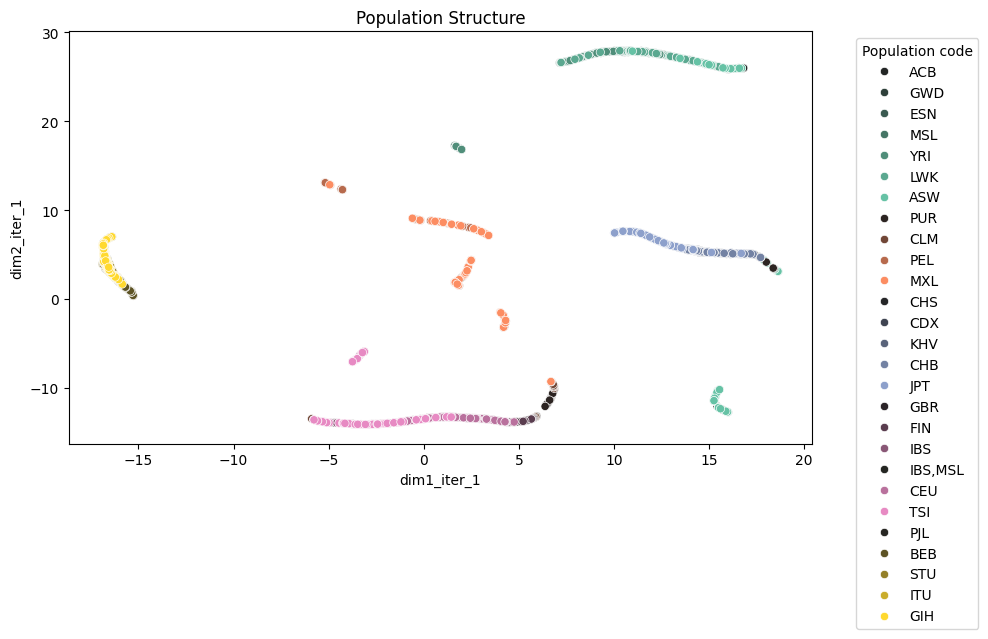

/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


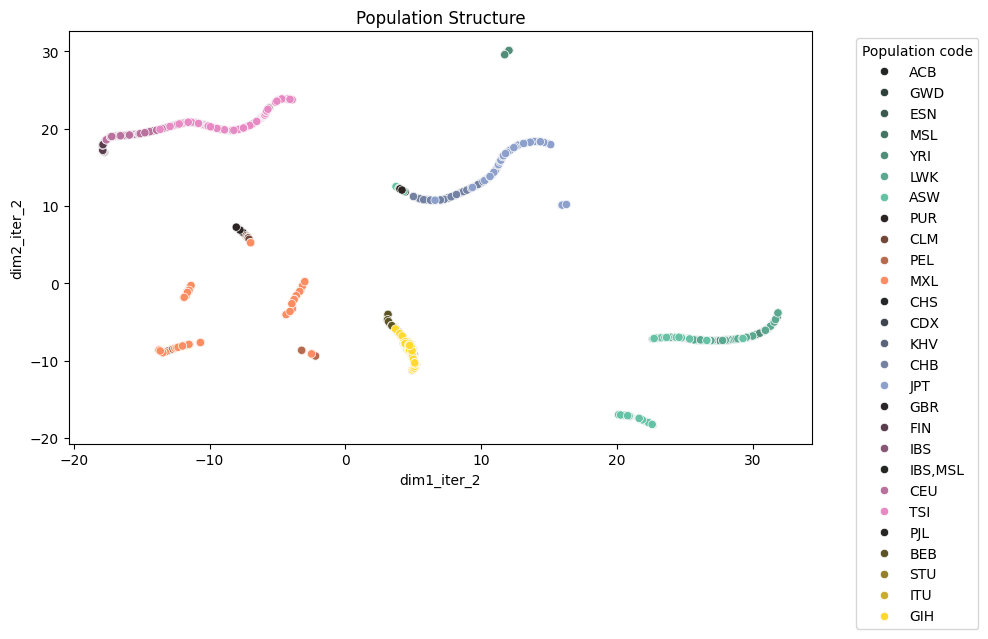

/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


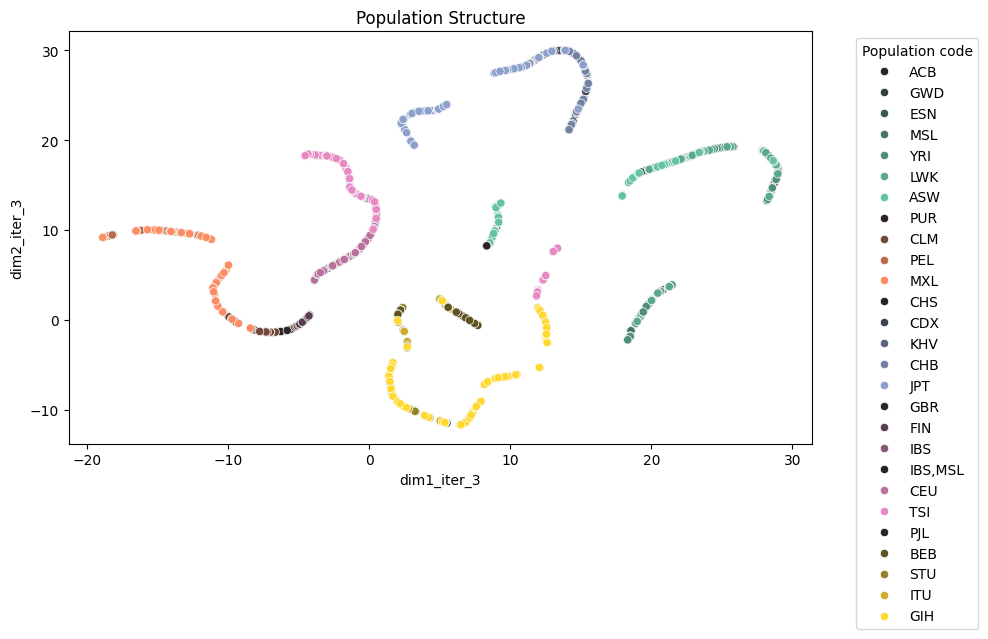

/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.8.12/envs/pca_projection/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


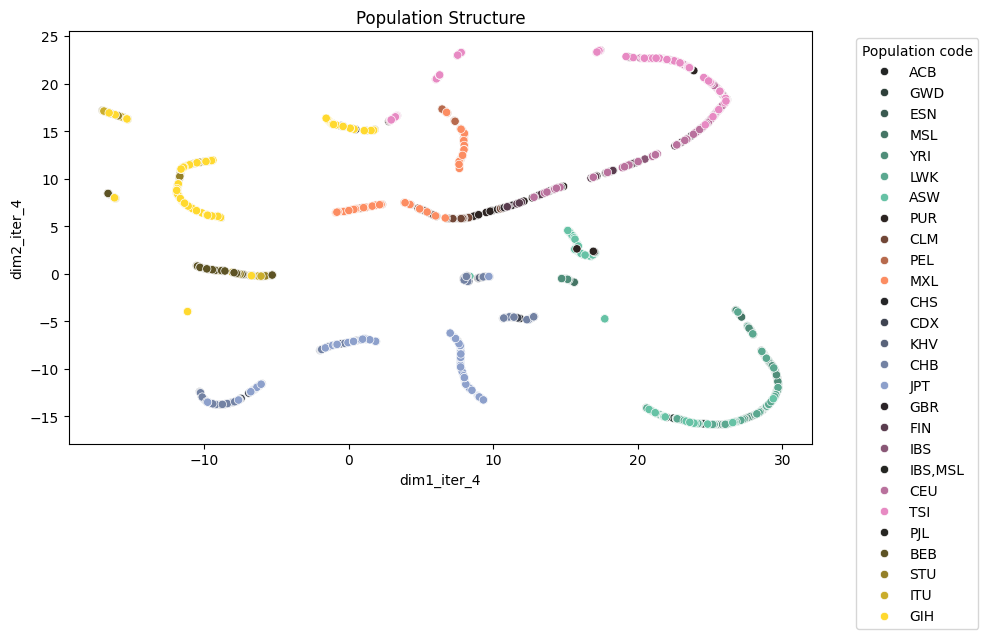

In [48]:
iterations = [f for f in os.listdir(f"{CONFIG['PATH_data']}") if f.startswith('iteration')]
iterations.sort()
for iteration in iterations:
    iteration_nr = int(iteration.split('_')[1])
    path_output= f"{CONFIG['PATH_data']}/{iteration}/06_esti_Fst/"
    Fst_global = pd.read_pickle(f"{path_output}/global_Fst.pkl")
    reducer = umap.UMAP(metric='precomputed', random_state=42)
    embeddings = reducer.fit_transform(Fst_global)
    ids[[f"dim1_iter_{iteration_nr}", f"dim2_iter_{iteration_nr}"]] = embeddings
    make_population_plot(ids, f"dim1_iter_{iteration_nr}", f"dim2_iter_{iteration_nr}", 'Population code', 'Superpopulation code', "Population Structure")
